<a href="https://colab.research.google.com/github/Sipten-raza/Deep-Learning/blob/main/Notebooks/Chap10/10_5_Convolution_For_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 10.5: Convolution for MNIST**

This notebook builds a proper network for 2D convolution.  It works with the MNIST dataset (figure 15.15a), which was the original classic dataset for classifying images.  The network will take a 28x28 grayscale image and classify it into one of 10 classes representing a digit.

The code is adapted from https://nextjournal.com/gkoehler/pytorch-mnist

Work through the cells below, running each cell in turn. In various places you will see the words "TODO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.


In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random

In [2]:
import torch
import torchvision

batch_size_train = 64
batch_size_test = 1000

# TODO: Change this directory to point towards an existing directory
# Specify the directory where you want the MNIST data to be stored
# If you want to store it in the current directory, you can set it like this:
myDir = './data'  # Change this to the path where you want to save MNIST

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(myDir, train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))  # Normalization values for MNIST
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(myDir, train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))  # Normalization values for MNIST
                             ])),
  batch_size=batch_size_test, shuffle=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 22.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 616kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.55MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.36MB/s]


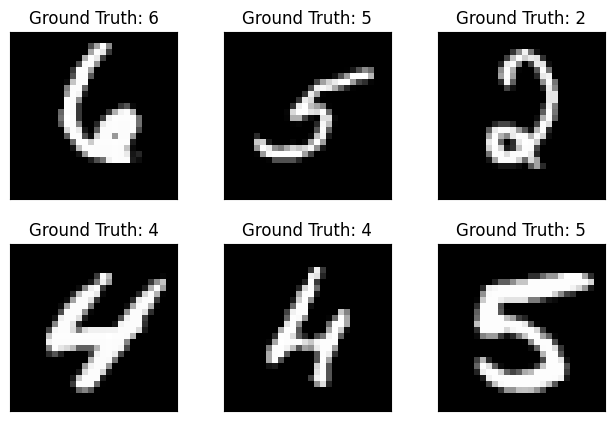

In [3]:
# Let's draw some of the training data
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

Define the network.  This is a more typical way to define a network than the sequential structure.  We define a class for the network, and define the parameters in the constructor.  Then we use a function called forward to actually run the network.  It's easy to see how you might use residual connections in this format.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Valid convolution: 1 input channel, 10 output channels, kernel size = 5
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)

        # Max pooling operation over 2x2 area
        self.pool = nn.MaxPool2d(2, 2)

        # Second convolution: 10 input channels, 20 output channels, kernel size = 5
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)

        # Dropout layer
        self.dropout = nn.Dropout2d(0.25)  # 25% dropout

        # Fully connected layer 1: input size to be calculated, output 50
        # Assuming input image size is 28x28 (standard MNIST)
        # After two convolutions and pooling, the output size will be reduced.
        # Let's calculate this dynamically based on the input size after convolutions.
        self.fc1_input_dim = self._get_fc1_input_dim(28)  # Assuming input size is 28x28

        self.fc1 = nn.Linear(self.fc1_input_dim, 50)
        self.fc2 = nn.Linear(50, 10)  # Output size 10 (for 10 classes)

    def _get_fc1_input_dim(self, size):
        # Calculate the size after two convolutions and two pooling layers
        size = size - 4  # Kernel size = 5 reduces size by 4 (valid padding)
        size = size // 2  # After first pooling (size/2)
        size = size - 4  # Kernel size = 5 reduces size by 4
        size = size // 2  # After second pooling (size/2)
        return size * size * 20  # 20 output channels from conv2

    def forward(self, x):
        # Convolution 1
        x = self.conv1(x)
        x = F.relu(x)  # ReLU
        x = self.pool(x)  # Max pooling

        # Convolution 2
        x = self.conv2(x)
        x = F.relu(x)  # ReLU
        x = self.pool(x)  # Max pooling

        # Dropout
        x = self.dropout(x)

        # Flatten the output from convolution layers to input the fully connected layer
        x = x.flatten(1)

        # Fully connected layer 1
        x = self.fc1(x)
        x = F.relu(x)  # ReLU

        # Fully connected layer 2 (output layer)
        x = self.fc2(x)

        # Softmax output for classification
        x = F.log_softmax(x, dim=1)
        return x


In [5]:
# He initialization of weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

In [6]:
# Create network
model = Net()
# Initialize model weights
model.apply(weights_init)
# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [7]:
# Main training routine
def train(epoch):
  model.train()
  # Get each
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    # Store results
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset), loss.item()))

In [8]:
# Run on test data
def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [9]:
# Get initial performance
test()
# Train for three epochs
n_epochs = 3
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.4234, Accuracy: 419/10000 (4%)

Train Epoch: 1 [0/60000]	Loss: 2.561246
Train Epoch: 1 [640/60000]	Loss: 2.235876
Train Epoch: 1 [1280/60000]	Loss: 2.054916
Train Epoch: 1 [1920/60000]	Loss: 2.048250
Train Epoch: 1 [2560/60000]	Loss: 1.773704
Train Epoch: 1 [3200/60000]	Loss: 1.373061
Train Epoch: 1 [3840/60000]	Loss: 1.227337
Train Epoch: 1 [4480/60000]	Loss: 1.341457
Train Epoch: 1 [5120/60000]	Loss: 0.657430
Train Epoch: 1 [5760/60000]	Loss: 0.767942
Train Epoch: 1 [6400/60000]	Loss: 0.595340
Train Epoch: 1 [7040/60000]	Loss: 0.572404
Train Epoch: 1 [7680/60000]	Loss: 0.739498
Train Epoch: 1 [8320/60000]	Loss: 0.439278
Train Epoch: 1 [8960/60000]	Loss: 0.484560
Train Epoch: 1 [9600/60000]	Loss: 0.675494
Train Epoch: 1 [10240/60000]	Loss: 0.443406
Train Epoch: 1 [10880/60000]	Loss: 0.430733
Train Epoch: 1 [11520/60000]	Loss: 0.656536
Train Epoch: 1 [12160/60000]	Loss: 0.561109
Train Epoch: 1 [12800/60000]	Loss: 0.436742
Train Epoch: 1 [13440/60000]	Loss: 0.226

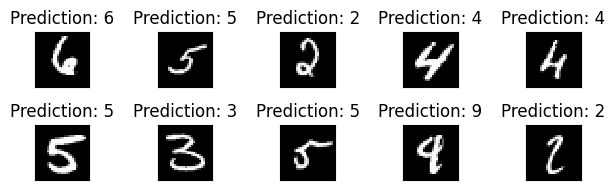

In [10]:
# Run network on data we got before and show predictions
output = model(example_data)

fig = plt.figure()
for i in range(10):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
plt.show()